In [2]:
"""
Arjun Srivastava
arj1
AMATH 301 B
"""

import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Problem 1

A = np.genfromtxt('hw4_matrix.csv', delimiter=',')

# a)

b = np.random.rand(20, 1)
x = scipy.linalg.solve(A, b)
print(np.array_equal(A @ b, x))

"""
||Ax-b||oo is the error of the solution as we approach infinitely many iterations. I think it is reasonable to pretend this
is zero, since it should be equal to 0 by mathematical definition. There is, of course, a degree of rounding error, which
is why Ax is not exactly equal to b.
"""

# b)

tolerance = 10e-4
err = tolerance + 1
P = np.diag(np.diag(A))
T = A - P
x0 = np.ones(b.shape)
X = np.zeros(b.shape)
X[:, 0:1] = x0

k = 0
M = -scipy.linalg.solve(P, T)
w, V = np.linalg.eig(M)
err_jacobi = []
if np.max(np.abs(w)) < 1:
    while err >= tolerance:
        X = np.hstack((X, scipy.linalg.solve_triangular(P, -T @ X[:, k:(k+1)] + b)))
        err = np.max(np.abs(X[:, k+1] - X[:, k]))
        k = k + 1
        err_jacobi.append(np.max(np.abs(x)) - np.max(np.abs(X)))
        
ks = np.arange(0, k)

# c)

P = np.tril(A)
T = A - P
err = tolerance + 1
X = np.zeros(b.shape)
X[:, 0:1] = x0
k = 0

M = -scipy.linalg.solve(P, T)
w, V = np.linalg.eig(M)
err_gauss = []
if np.max(np.abs(w)) < 1:
    while err >= tolerance:
        X = np.hstack((X, scipy.linalg.solve_triangular(P, -T @ X[:, k:(k+1)] + b, lower=True)))
        err = np.max(np.abs(X[:, k+1] - X[:, k]))
        k = k + 1
        err_gauss.append(np.max(np.abs(x)) - np.max(np.abs(X)))
ks1 = np.arange(0, k)

False


Text(0.5, 1.0, 'Error Comparisons for Jacobi and Gauss-Seidel Matrix splitting (log)')

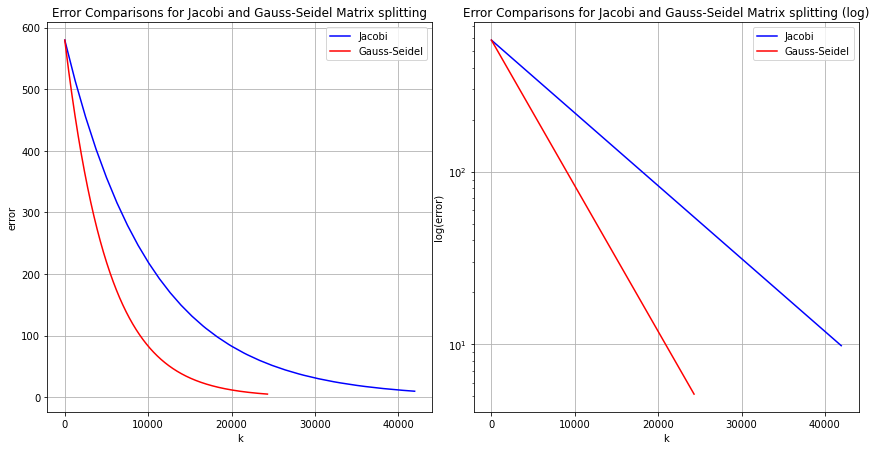

In [69]:
# d)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
fig.tight_layout()
axs[0].grid(), axs[1].grid()
axs[0].plot(ks, err_jacobi, 'b')
axs[0].plot(ks1, err_gauss, 'r')
axs[0].set_xlabel('k')
axs[0].set_ylabel('error')
axs[0].set_title('Error Comparisons for Jacobi and Gauss-Seidel Matrix splitting')
axs[0].legend(['Jacobi', 'Gauss-Seidel'])

# e)

axs[1].semilogy(ks, err_jacobi, 'b')
axs[1].semilogy(ks1, err_gauss, 'r')
axs[1].set_ylabel('log(error)')
axs[1].set_xlabel('k')
axs[1].legend(['Jacobi', 'Gauss-Seidel'])
axs[1].set_title('Error Comparisons for Jacobi and Gauss-Seidel Matrix splitting (log)')

# f)

"""
The slopes from the semilogy graph (log(error)/k) represent the change in error per guess. This makes sense due to the negative
slope--as the guesses continue, the error slowly approaches 0 and the function converges. Essentially, the slope tells us the
speed of the splitting method. A slope with a greater absolute magnitude will reach the minimum error tolerance more quickly.
"""

'\nThe optimized SOR method was about 25 times faster than the (slowest) Jacobi method. For this reason, I think it could be worth\nit to find the optimal omega value.\n'

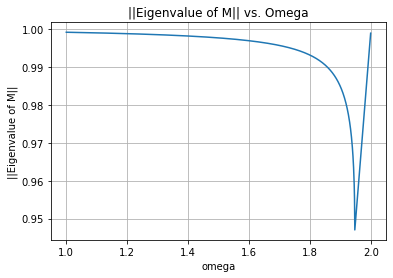

In [4]:
# Problem 2

# Function to generate discrete Poisson matrix of given dimension
def discrete_poisson(dim: int):
    A = np.zeros((dim, dim))
    np.fill_diagonal(A, 2), np.fill_diagonal(A[1:], -1), np.fill_diagonal(A[:, 1:], -1)
    return A

A = discrete_poisson(114)
rho = np.fromfunction(lambda j, i: 2 * (1 - np.cos(53*np.pi / 115)) * np.sin((53*np.pi*j)/115), (114, 1))

D = np.diag(np.diag(A))
U = np.triu(A, 1)
L = np.tril(A, -1)

# a)

omegas = np.arange(1, 1.999, .001)
lambdas = []

for omega in omegas:
    P = ((1/omega) * D) + L
    T = (((omega - 1)/omega) * D) + U
    M = -scipy.linalg.solve(P, T)
    w, V = np.linalg.eig(M)
    lambdas.append(np.max(np.abs(w)))
    
plt.plot(omegas, lambdas)
plt.title('||Eigenvalue of M|| vs. Omega')
plt.xlabel('omega')
plt.ylabel('||Eigenvalue of M||')
plt.grid()

# b)

"""
I do think the value of omega will influence the speed of the algorithm. I do not, however, think the difference in speed will
be very significant. When comparing the speed of the Jacobi method versus the Gauss-Seidel method, the Gauss-Seidel method
was faster mainly because the max eigenvalue was two times smaller than that of the Jacobi method. In this case, the smallest
eigenvalue seems to be around 0.973, which is not much smaller than 1. The corresponding omega value seems to be around 1.9
"""

# c)

omega_best = omegas[np.argmin(lambdas)]  # lambda = 0.9729999999998943 (the lowest point on the graph), omega_best = 1.947

# d)

P = ((1/omega_best) * D) + L
T = (((omega_best - 1)/omega_best) * D) + U
tolerance = 10e-5
err = tolerance + 1
x0 = np.ones((114, 1))
X = np.zeros((114, 1))
X[:, 0:1] = x0
k = 0
while err >= tolerance:
    X = np.hstack((X, scipy.linalg.solve_triangular(P, -T @ X[:, k:(k+1)] + rho, lower=True)))
    err = np.max(np.abs(X[:, k+1] - X[:, k]))
    k += 1
    
"""
The SOR method using an optimized omega value of 1.947 only takes 229 guesses to reach a solution within the tolerance bounds.
For reference, the Jacobi method took 5716 guesses, the Gauss-Seidel method took 3046 guesses, and the unoptimized SOR method
with omega = 1.5 took 1525 guesses. In summary, the optimized SOR method is much faster than every other method, which surprised
me.
"""

# e)

"""
The optimized SOR method was about 25 times faster than the (slowest) Jacobi method. For this reason, I think it could be worth
it to find the optimal omega value. At the same time though, the unoptimized SOR method took under 5 seconds to compute an estimate
within the tolerance, while the supposedly "optimized" SOR method took over 20 seconds. This time increase is likely due to the
eigenvalue argmin calculations, which negate the decrease in time associated with fewer steps. Overall, I don't think optimizing
for the best omega value is in the best interest of time to solve a single system. If we needed to solve multiple systems with
the same matrix A, however, finding the optimal omega would surely be worth it since we would only need to do it once. In summary,
I would not find the optimal omega for a single system, but I would for solving multiple systems.
"""